# ADA Project:  Determining the political orientation of the New York Times newspaper through quotes analysis

This notebook contains the initial analysis of the quotebank dataset, that consists of quotations from multiple newspapers published between 2015 and 2020. The final goal of this project is to define the political orientation of the New-York Times newspaper, mainly based on the distribution of republican and democratic oriented quotations.
The determination of the political orientation will be based on several chosen topics that are commonly addressed in the USA and on which republicans and democrats tend to argue. We will use dictionaries to select the interesting quotations and will apply unsupervized machine learning techniques combined with sentiment analysis to highlight the separation of political opinions in the quotes. 

Before begining the proper analysis of the quotebank, an initial analysis and preprocessing of the data is required. Therefore, the following steps will be performed: 

1. Data loading
2. Basic pre-processing
3. Quotations cleaning
4. Speakers cleaning
5. Initial visualization of the dataset
6. First step towards sentiment analysis

Here is a visual description of the project pipeline:

![Project pipeline](data/images/Schema_steps.png)

Finally, an complementary dataset will be used in this project, containing further information about the speakers identified in the quotebank such as nationality, party and more.


Note that this notebook should be run after running the `project_pt1_loading.ipynb ` notebook dedicated to the loading of the complete 2015-2020 quotebank, selection of the New York Times quotations and creation of a tokenized version of the quotations. In the latter , all of these steps are saved into compressed json file that will be loaded in this `project_pt2_analyses.ipynb` notebook. 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import bz2
import json
import os

import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
import spacy  # NLP library
from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## 1. Data loading


The main dataset used in the project is the quotebank, an open corpus of millions of quotations attributed to the speakers who uttered them, extracted from a lot of news articles published in english between 2015 and 2020. 

The complete dataset contains the following information: 

- `quoteID`: used to identify the quotation.
- `quotation`: the quotation published in the article.
- `speaker`: the name of the person with the highest probability of being the speaker. The speaker is set to None if they were not found. 
- `qids`: used to identify the speaker, if any.
- `date`: the publication date of the quotation.
- `numOccurences`: the number of occurences of the quotation in the newspapers.
- `probas`: the probability for different people to be the speaker.
- `urls`: the urls of the article in which the quotation was found.
- `phase`: related to the processing of the quotation when building the quotebank.

The given dataset is divided in 6 json files according to the year of publication (2015-2020).
As it is a very large dataset and since we're only interested in a portion of it, we only selected the New York times quotations before loading the data. This step was performed in the first notebook `project_pt1_loading.ipynb`. Here, we load the 6 reduced size json files obtained after running the latter notebook and assembly them to get one final dataframe.

In [3]:
# Used for loading the json.bz2 files
def bz2_to_dataframe(path):
    """Creates a dataframe from a compressed json.bz2 file."""
    
    with bz2.open(path, 'rb') as file:
        lines = file.readlines()
    data = list(map(json.loads, lines))
    return pd.DataFrame(data)

In [4]:
 # Load the json.bz2 files into one dataframe
def create_NYT_dataframe():
    """Creates the NYT dataframe from the json.bz2 files."""
    
    DIR_PATH = '/content/drive/Shareddrives/ADA/NewYorkTimes'

    # Create the dataframes by year
    dataframes = list()
    for year in range(2015, 2021):
        filename = f'nyt-quotes-{year}.json.bz2'
        print('Loading', filename)
        path = os.path.join(DIR_PATH, filename)
        dataframe = bz2_to_dataframe(path)
        dataframes.append(dataframe)

    # Concatenate the dataframes
    return pd.concat(dataframes, ignore_index=True)

In [5]:
# Create main dataframe
data_NYT = create_NYT_dataframe()
data_NYT

Loading nyt-quotes-2015.json.bz2
Loading nyt-quotes-2016.json.bz2
Loading nyt-quotes-2017.json.bz2
Loading nyt-quotes-2018.json.bz2
Loading nyt-quotes-2019.json.bz2
Loading nyt-quotes-2020.json.bz2


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-02-27-014158,drilling a hole in the windshield.,Alex Stamos,[Q50822408],2015-02-27 19:58:47,10,"[[Alex Stamos, 0.6337], [None, 0.2113], [Micha...",[http://www.nextgov.com/cybersecurity/2015/02/...,E
1,2015-10-02-055672,It's a missed opportunity to raise the price o...,David Keyes,[Q5235979],2015-10-02 17:54:14,1,"[[David Keyes, 0.4883], [Mohammad Javad Zarif,...",[http://mobile.nytimes.com/blogs/opinionator/2...,E
2,2015-01-29-030054,I hated feeling constrained or constricted.,Leith Clark,[Q57293123],2015-01-29 00:37:03,1,"[[Leith Clark, 0.8648], [None, 0.1272], [Simon...",[http://rss.nytimes.com/c/34625/f/640335/s/42c...,E
3,2015-08-23-022061,"I stand for our generation, and our generation...",Wiz Khalifa,[Q117139],2015-08-23 18:20:48,19,"[[Wiz Khalifa, 0.5741], [None, 0.3923], [Justi...",[http://www.maxim.com/tech/article/let-wiz-kha...,E
4,2015-04-04-033010,"Stop thinking, and end your problems,",None,[],2015-04-04 13:06:36,8,"[[None, 0.8494], [Aaron Beck, 0.1506]]","[http://www.examiner.com/node/77457837, http:/...",E
...,...,...,...,...,...,...,...,...,...
858362,2020-02-07-100927,trying to understand my own culture.,None,[],2020-02-07 15:00:10,2,"[[None, 0.7619], [Tania León, 0.2381]]",[http://mobile.nytimes.com/2020/02/07/arts/mus...,E
858363,2020-03-11-075732,"We Hanks' will be tested, observed, and isolat...",Tom Hanks,[Q2263],2020-03-11 00:00:00,53,"[[Tom Hanks, 0.6479], [None, 0.3087], [Rita Wi...",[http://www.dailyherald.com/news/20200311/tom-...,E
858364,2020-01-19-049886,we immediately initiated an investigation and ...,None,[],2020-01-19 18:08:35,7,"[[None, 0.6967], [Isabel dos Santos, 0.249], [...",[http://mobile.nytimes.com/2020/01/19/world/af...,E
858365,2020-01-26-053553,"Well, Joe, you're wrong.",Bernie Sanders,[Q359442],2020-01-26 17:01:39,10,"[[Bernie Sanders, 0.8208], [None, 0.1573], [Jo...",[https://www.nytimes.com/live/2020/iowa-democr...,E


## 2. Basic data preprocessing
Once the dataset is loaded, some basic preprocessing steps are performed to detect any abnormalities and clean the data, to make it usable for any further analyses.


#### Remove useless columns
We start with a data size reduction by removing the useless columns. In our case, `probas`, `phase` and `urls` are removed. Note that the urls can be removed since we already selected the New York Times quotations during the loading (see `project_pt1_loading.ipynb `).

In [6]:
# Drop some useless columns
print('Initial data size:', data_NYT.shape)

# Drop useless columns
labels_to_remove = ['phase', 'probas', 'urls']
data_NYT = data_NYT.drop(labels_to_remove, axis=1)

print('Final data size:', data_NYT.shape)

Initial data size: (858367, 9)
Final data size: (858367, 6)


#### Handle abnormalities
It is now time to check the unicity of the `quoteID` and make sure that the data do not contain any abnormal missing entries.


In [7]:
# Applied on any new dataframe
def remove_abnormalities(df, ind):

    """
    Preprocess and check any abnormalities in the data:
    - set ind as index
    - check and remove duplicated rows
    - check presence of missing entries
    """

    # Set index
    df = df.set_index(ind)  
    print('All indices are unique:', df.index.is_unique)

    # Remove duplciated rows
    if not (df.index.is_unique):
        df = df[~df.index.duplicated(keep='first')]
        print('Duplicated rows were removed')

    # Check for missing entries anywhere in the dataframe
    print('Presence of missing entries:', df.isna().values.any())
    
    return df

In [8]:
data_NYT = remove_abnormalities(data_NYT, 'quoteID')

All indices are unique: True
Presence of missing entries: False


#### Change columns types
Finally, the type of each column is changed for the most appropriate one. More precisely, it is important for `quotation` and `speaker` to be set to string. For now, we want `qids` to be interpreted as object since some speakers still have mutliple qids. This will be taken care of later in our analysis.

In [9]:
# Check types
data_NYT.dtypes

quotation         object
speaker           object
qids              object
date              object
numOccurrences     int64
dtype: object

In [10]:
# Change the types to the appropriate ones
data_NYT = data_NYT.convert_dtypes()

# Change type of date into datetime type
data_NYT['date'] = pd.to_datetime(data_NYT['date'])

# Check types
data_NYT.dtypes

quotation                 string
speaker                   string
qids                      object
date              datetime64[ns]
numOccurrences             Int64
dtype: object

## 3. Quotations cleaning
The quotations require additional processing.
Remember that in order to classify the quotations, we would ultimately have to compare the quotes with dictionaries. It is therefore important to clean the quotations to make this step easier. 

We decided to keep one raw version of the quotations, in case we have to print them, and to have a corresponding cleaned version of them that will be used for our analyses.

#### Tokenize and lemmatize text
We first tokenize and lemmatize the quotations.
We use tokenization to chop each tweet into a collection of individual words (i.e. tokens). Applying lemmatization aims to cut each word down to its base form. For example: laugh, laughs, laughing, laughed would all be reduced to laugh. This reduces the complexity of analysis by reducing the number of unique words. Both techniques are built into the spaCy package, which was used in the `text_tokenizer` function. This function was run in the other notebook to create the tokenized version of the quotations and save it as compressed json file. 

Here, we load the tokenized version of the quotations from the json file and after cleaning it, we add it to the `data_NYT` as an additional column named `tokenized_quotations`. We will later perform our analyses on this specific version of the quotations.

In [11]:
# Load tokenized column from json file
PATH_TOKEN = '/content/drive/Shareddrives/ADA/tokenizer/tokenizer_column_data_NYT.json.bz2'
tokenized_data = bz2_to_dataframe(PATH_TOKEN)

tokenized_data

,quoteID,tokenized_quotations
0,2020-02-18-004289,an appetite for power .
1,2020-01-09-006199,Andrew Yang 's lie about support Medicare for ...
2,2020-01-22-017789,eager to erase the image of congressional Repu...
3,2020-01-31-022641,give the partisan nature of this impeachment f...
4,2020-01-23-024008,"-PRON- get on top of -PRON- , and -PRON- rape ..."
...,...,...
858362,2015-12-14-009516,be the healthy Individual ever elect to the Pr...
858363,2015-11-10-015262,change be inevitable -- -PRON- be the progress...
858364,2015-10-15-044368,"-PRON- just do not fit in ,"
858365,2015-09-15-104423,think to Win : the Strategic Dimension of Tenn...


#### Clean texts
We now clean the tokenized quotations from the following characteristics:

- *line breaks*
- *numbers*
- *punctuation*
- *capital letters (set to small letters)*

and finally the 'pron' coming from the lemmatization of the quotations and corresponding to pronouns.

In [12]:
# Text cleaner function, applied on quotations and later on speakers
def text_cleaner(text):

    """
    Preprocess the text in the data:
    - remove the line breaks
    - remove the punctuation
    - remove the capital letters
    """

    text = text.replace('\n', ' ')  # remove line breaks
    text = text.str.replace('\w*\d\w*', '') # remove numbers
    text = text.str.replace(r'[^\w\s]', '')  # remove punctuation
    text = text.str.lower()  # remove capital letters
    return text


# Clean quotations
tokenized_data.tokenized_quotations = text_cleaner(tokenized_data.tokenized_quotations)

# Remove the 'pron' in the quotations caused by lemmatization
tokenized_data.tokenized_quotations = tokenized_data.tokenized_quotations.str.replace('pron', '') 

In [13]:
# Convert the types to allow the merge and set quoteID as index
tokenized_data = tokenized_data.convert_dtypes()
tokenized_data = tokenized_data.set_index('quoteID')

# Add tokenized_quotations to the data set. 
data_NYT = data_NYT.merge(tokenized_data, how='left', on='quoteID')
data_NYT

,quotation,speaker,qids,date,numOccurrences,tokenized_quotations
quoteID,,,,,,
2015-02-27-014158,drilling a hole in the windshield.,Alex Stamos,[Q50822408],2015-02-27 19:58:47,10,drill a hole in the windshield
2015-10-02-055672,It's a missed opportunity to raise the price o...,David Keyes,[Q5235979],2015-10-02 17:54:14,1,be a miss opportunity to raise the price on d...
2015-01-29-030054,I hated feeling constrained or constricted.,Leith Clark,[Q57293123],2015-01-29 00:37:03,1,hate feel constrain or constrict
2015-08-23-022061,"I stand for our generation, and our generation...",Wiz Khalifa,[Q117139],2015-08-23 18:20:48,19,stand for generation and generation be gon...
2015-04-04-033010,"Stop thinking, and end your problems,",None,[],2015-04-04 13:06:36,8,stop think and end problem
...,...,...,...,...,...,...
2020-02-07-100927,trying to understand my own culture.,None,[],2020-02-07 15:00:10,2,try to understand own culture
2020-03-11-075732,"We Hanks' will be tested, observed, and isolat...",Tom Hanks,[Q2263],2020-03-11 00:00:00,53,hanks will be test observe and isolate for...
2020-01-19-049886,we immediately initiated an investigation and ...,None,[],2020-01-19 18:08:35,7,immediately initiate an investigation and be ...


## 4. Speakers cleaning
Now that the quotations are well preprocessed, we focus on the speakers. Some quotations are attributed to known speakers and some aren't. Ultimately, we would need to perform analyses on the identified speakers. Therefore, we form a reduced size dataset named `speakers` from the complete dataset `data_NYT` by extracting the quotations attributed to only known speakers. `speakers` will be then extended using an external dataset given as a '.parquet' file composed of additional information on many speakers. 
In the end, we will have two sets of data:
1. `speakers` regrouping the quotations and their identified speakers with essential information on themselves and 
2.  `data_NYT` the original dataset. 

Note that both will be used for different purposes in the final project(see the README for more details).


#### Clean speakers from DATA_NYT 
Before extracting the speakers and their quotations from the original dataset, we have to identify them and check that there is no  misunderstanding concerning the person at the origin of each quotation. 

First, let's clean the `speaker` column using the same `text_cleaner` function that we used previously for quotations. 

In [14]:
# Clean speaker text
data_NYT['speaker'] = text_cleaner(data_NYT['speaker'])

As observed in the dataset, some speakers have been attributed mutliple qids. This is obviously an error related to the homonyms of some speakers. Indeed, different speakers are labeled with the same name but are repertoriated each with different qids since it is actually different people. The model used to create this quotebank could probably not differenciate between the different homonyms and thus kept all the qids corresponding to the label. 

For our project, we have to take care of this problem because we want to relate the quotation to the speaker, its party and other additional information on them. However, we have no way to actually know which of the qids corresponds to the true speaker, therefore we treat all speakers with multiple qids as unknown speakers, by setting the `speaker` value to 'None'.

In [15]:
# Check if speakers have multiple qids
print('Number of speakers with multiple qids: {}' .format(
    data_NYT[data_NYT.qids.apply(lambda x: len(x) > 1)].shape[0]))

# Speaker with mutliple qids are set to none
data_NYT.loc[data_NYT.qids.apply(lambda x: len(x) > 1), 'speaker'] = 'none'

Number of speakers with multiple qids: 118231


Now that the known speakers are precised, we form the additional `speakers` dataset. Additionally, because each speaker has now only one qids, we can set the type of `qids` as string.

In [16]:
# Define an additional dataset containing only speakers 
speakers = data_NYT.loc[data_NYT['speaker'] != 'none']
print('Number of known speakers: ', speakers.shape[0])

# Change qids type into string
speakers.qids = speakers.qids.str.get(0)  # remove brackets
speakers.qids = speakers.qids.astype('string')

# Explore additional dataset
speakers

Number of known speakers:  433909


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,quotation,speaker,qids,date,numOccurrences,tokenized_quotations
quoteID,,,,,,
2015-02-27-014158,drilling a hole in the windshield.,alex stamos,Q50822408,2015-02-27 19:58:47,10,drill a hole in the windshield
2015-10-02-055672,It's a missed opportunity to raise the price o...,david keyes,Q5235979,2015-10-02 17:54:14,1,be a miss opportunity to raise the price on d...
2015-01-29-030054,I hated feeling constrained or constricted.,leith clark,Q57293123,2015-01-29 00:37:03,1,hate feel constrain or constrict
2015-08-23-022061,"I stand for our generation, and our generation...",wiz khalifa,Q117139,2015-08-23 18:20:48,19,stand for generation and generation be gon...
2015-11-30-103188,the whole has to be included,angela merkel,Q567,2015-11-30 00:00:00,8,the whole have to be include
...,...,...,...,...,...,...
2020-02-03-062993,Research continues on other approaches to a sa...,anthony fauci,Q573246,2020-02-03 00:00:00,40,research continue on other approach to a safe ...
2020-04-10-038765,strong controls and protections for user privacy.,sundar pichai,Q3503829,2020-04-10 12:51:46,4,strong control and protection for user privacy
2020-03-11-075732,"We Hanks' will be tested, observed, and isolat...",tom hanks,Q2263,2020-03-11 00:00:00,53,hanks will be test observe and isolate for...


#### Clean external dataset: speakers information 

`speakers` will be extended with personal information for each person. These information are regrouped in a given '.parquet' file that is loaded. In the loading, we only select the information that will be pertinent to add in our data such as: 
- `aliases`: the different names that are used to name the person. This information will be useful if we want to identify the quotations in which the given speaker was cited, and ultimatley create a political map.
- `id`: similar to the qids in the other dataset. This column will be used to merge the `speakers_info` to the `speakers` dataset.
- `nationality`: referred as a wikidata item. We need to know the nationality of the speakers because we will have to focus on the american speakers to classify them as republican, democrats, other party or none.
- `US_congress_bio_ID`:  member IDs from the "Biographical Directory of the United States Congress". This information will help us know how important in the political world the person is.
- `party`: the party to which the speaker belongs to, referred as wikidata item. Multiple items are sometimes repertoriated for one person. This will be taken care of later. This column will be particularly helpful to determine the repartition between republicans and democrats. The parties will be later classified in 4 different groups.
- `label`: the label that is used to name the person. As this information is redundant, we will merge this column with the `speaker` column later in the notebook.


In [17]:
# Load parquet file
SPEAKER_PATH = '/content/drive/Shareddrives/ADA/speaker_attributes.parquet'
SPEAKER_COLUMNS = ['aliases', 'id', 'nationality',
                   'US_congress_bio_ID', 'party', 'label']

speakers_info = pd.read_parquet(SPEAKER_PATH, columns=SPEAKER_COLUMNS)
speakers_info

,aliases,id,nationality,US_congress_bio_ID,party,label
0,"[Washington, President Washington, G. Washingt...",Q23,"[Q161885, Q30]",W000178,[Q327591],George Washington
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",Q42,[Q145],None,None,Douglas Adams
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",Q1868,[Q31],None,None,Paul Otlet
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",Q207,[Q30],None,[Q29468],George W. Bush
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",Q297,[Q29],None,None,Diego Velázquez
...,...,...,...,...,...,...
9055976,[Barker Howard],Q106406560,[Q30],None,None,Barker B. Howard
9055977,[Charles Macomber],Q106406571,[Q30],None,None,Charles H. Macomber
9055978,None,Q106406588,None,None,None,Dina David
9055979,None,Q106406593,None,None,None,Irma Dexinger


As for the other dataset, we first clean the data using the same function `text_cleaner`, and then check for any abnormalities contained in the dataset using `remove_abnormalities`. 

In [18]:
# Remove capital letters punctuation and possible line breaks in label and aliases
speakers_info['label'] = text_cleaner(speakers_info['label'])
speakers_info['aliases'] = text_cleaner((speakers_info['aliases']).astype(str))

# Remove abnormalities such as missing entries and duplicated rows
speakers_info = remove_abnormalities(speakers_info, 'id')

All indices are unique: True
Presence of missing entries: True


Some entries seem to be missing. Let's look at them more into details. If the information concerning the `nationality` are missing, it is not important. Indeed, we would simply not use these information since it is not accessible. Similarly, if the `aliases`, `party` or `US_congress_bio_ID` contain missing entries, it means that the speaker does not have a repertoriated alias, party nor congress id and this doesn't import us and shouldn't be understood as a data error.

However, we would like to make sure that neither the `id` nor the `label` are missing. Indeed, if the label is missing we could have some problems identifying the person. It could be that the `id` was mistaken and doesn't correspond to any speaker. However, we will take care of this problem after the merge if it is still present.



In [19]:
# Check for missing ids and labels
print('Some ids are missing: ', not(speakers_info.loc[speakers_info.index.isna()].empty))
print('Some labels are missing: ', not(speakers_info.loc[speakers_info.label.isna()].empty))


Some ids are missing:  False
Some labels are missing:  True


No ids are missing, thus we will have no problem when merging `speakers_info` with `sepakers`.

As already done for the previous dataset, we convert the type of each column into the most appropriate one.

In [20]:
# Check types
speakers_info.dtypes

aliases               object
nationality           object
US_congress_bio_ID    object
party                 object
label                 object
dtype: object

In [21]:
# Change the types to the appropriate ones
speakers_info = speakers_info.convert_dtypes()

# Check types
speakers_info.dtypes

aliases               string
nationality           object
US_congress_bio_ID    string
party                 object
label                 string
dtype: object

Some speakers may have multiple parties. The possible explanation is that the name of the parties changed or that the speaker changed its party.  We will only allow the speaker to have one party. We consider that the actual party is the last one. Additionally, we want to further analyze the us parties. Therefore, we select the american speakers and define them. We will classify the speakers into 4 categories according to the speaker's affiliated party: 'democratic party', 'republican party', 'other party', 'no party'.

In [22]:
# Check speakers with multiple parties and set them to last
print('Number of speakers affiliated to several political parties:', 
      speakers_info[speakers_info.party.apply(lambda x: np.size(x) > 1)].shape[0])

print('Affiliation to latest party...')

# Affiliate the last party to the speaker
speakers_info.party = speakers_info.party.apply(lambda x: 
                                                x[-1] if (np.size(x) > 1) else x)
print('Number of speakers affiliated to several political parties:', 
      speakers_info[speakers_info.party.apply(lambda x: np.size(x) > 1)].shape[0])

Number of speakers affiliated to several political parties: 32499
Affiliation to latest party...
Number of speakers affiliated to several political parties: 0


In [23]:
# Function used to classify the parties
def us_party_selection(df):

  ''' Classify the parties of speakers as following:
  - democrat: if one of the party of the speaker is democrat
  - republican: if one of the party of the speaker is republican
  - other: if the party of the speaker is not democrat neither republican
  - none: if the speaker has no party
  Only the us speakers are selected.
  '''

  # Drop non-american speakers and nationality column
  df = df[df.nationality.apply(lambda x: 'Q30' in str(x) )]
  df = df.drop(columns=['nationality'])

  # Set conditions for labelling
  mask_democrat = (df['party']=='Q29552')
  mask_republican = (df['party']=='Q29468')
  mask_no_party = (df.party.isna())
  
  # Create new column and setting it to 'other party' as default
  df['party_name'] = 'other party'
  df.loc[mask_democrat, 'party_name'] = 'democratic party'
  df.loc[mask_republican, 'party_name'] = 'republican party'
  df.loc[mask_no_party, 'party_name'] = 'no party'

  # Drop previous party column
  df = df.drop(columns=['party'])

  # Fixing column type
  df.party_name = df.party_name.astype('category')

  return df

Note that to find the labels corresponding to the american nationality, democratic party and republican party, we simply looked at the labels assigned to well-known speakers (Barack Obama for the Democratic Party, Trump for the Republican Party).

In [24]:
# Select the US speakers and attribute them to a party category
american_speakers = us_party_selection(speakers_info)

#### Merge speakers with speakers_info dataset

Since both `speakers` and `american_speakers` data set have been cleaned separately, we can now merge the two so that `speakers` is extended with the needed information.

In [25]:
# Check size of the two dataset
print(american_speakers.shape) # dataframe containing the info of american speakers
print(speakers.shape) # dataframe containing the New York Times quotes attributed to a defined speaker

(439876, 4)
(433909, 6)


In [26]:
# Merge speakers with speakers information
speakers = speakers.merge(american_speakers, right_index=True, left_on='qids')

Now let's focus on the label. There is a redundancy in the data since we have the `speaker` and  the `label`. Before merging the two, let's see if some speakers are named differently than their label.

In [27]:
# Check that all speakers have a label
print('All speakers have a label:', speakers.loc[speakers.label.isna().values].empty)

# Speakers with speaker names different from the label
speakers.loc[speakers.speaker != speakers.label]

All speakers have a label: True


,quotation,speaker,qids,date,numOccurrences,tokenized_quotations,aliases,US_congress_bio_ID,label,party_name
quoteID,,,,,,,,,,
2019-09-27-006846,are still being debated today.,bush jeb,Q221997,2019-09-27 18:26:13,1,be still be debate today,john ellis bush bush jeb john ellis jeb bush,<NA>,jeb bush,republican party
2019-09-27-016639,drifting toward another great systemic crisis.,bush jeb,Q221997,2019-09-27 18:26:13,1,drift toward another great systemic crisis,john ellis bush bush jeb john ellis jeb bush,<NA>,jeb bush,republican party
2015-10-01-088825,"something we should politicize,",president obama,Q76,2015-10-01 23:36:56,65,something should politicize,barack hussein obama ii barack obama ii barack...,O000167,barack obama,democratic party
2015-08-06-074929,Of all the foreign policy issues that I've add...,president obama,Q76,2015-08-06 20:32:38,1,of all the foreign policy issue that have add...,barack hussein obama ii barack obama ii barack...,O000167,barack obama,democratic party
2015-11-13-114357,Those that think they can terrorize the people...,president obama,Q76,2015-11-13 00:00:00,5,those that think can terrorize the people of ...,barack hussein obama ii barack obama ii barack...,O000167,barack obama,democratic party
...,...,...,...,...,...,...,...,...,...,...
2020-02-25-036721,It seems like there are certain optimal soluti...,kirk winemiller,Q29887892,2020-02-25 15:28:22,3,seem like there be certain optimal solution t...,kirk winemiller,<NA>,kirk o winemiller,no party
2020-03-13-061352,The reality is we were always the butt of the ...,adam carolla,Q4119,2020-03-13 16:48:05,1,the reality be be always the butt of the joke,adam lakers carolla ace rockolla recyclarolla ...,<NA>,adam carola,republican party
2020-03-13-029382,"If you go back and look at those bits, I think...",adam carolla,Q4119,2020-03-13 16:48:05,1,if go back and look at those bit think ever...,adam lakers carolla ace rockolla recyclarolla ...,<NA>,adam carola,republican party


Some speakers are actually named differently. Therefore, we replace the speaker column by the label. This way, we know that one speaker will always be named the same way.

Note that we don't have the problem of missing labels after merging, since all speakers are supposed to be known. 

In [28]:
# Replace the speaker with the label and remove label
speakers['speaker'] = speakers.label
speakers = speakers.drop(columns='label')

## 5. Visualization
Our preprocessing of the data is now done. We will do some visualizations to motivate our project.

#### Top speakers in the Ney York Times

We are first interested in the distribution of the speakers in the New York Times.
Identifying the top speakers is a first step towards the creation of the speakers network.

Text(0.5, 1.0, 'Top speakers in the NY Times between 2015 and 2020')

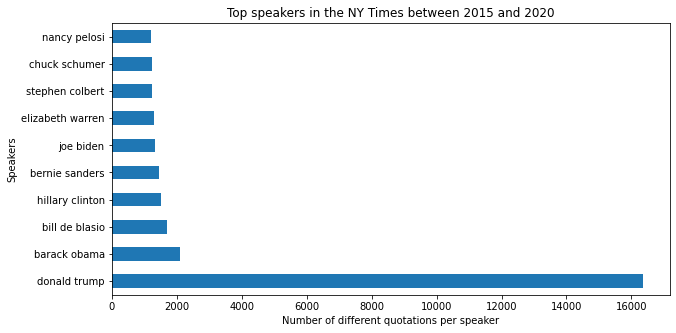

In [29]:
# Define top speakers
speakers['speaker'].value_counts().head(10).plot(kind='barh', figsize =(10, 5))
plt.xlabel('Number of different quotations per speaker')
plt.ylabel('Speakers')
plt.title('Top speakers in the NY Times between 2015 and 2020')

As observed in the graph, Donald Trump is by far the personality that is the most represented in the newspaper. Remember that the results are biased since he was the President of the US during almost the totality of the period. Should we remove it from the data then? We will answer this question later in our project, with the help of the speakers network.


### Word clouds

**Word cloud** is a technique for visualizing frequent words in a text where the size of the words represents their frequency. For this project, we can use this visualization tool to observe the most frequent words appearing in the quotes, and observe whether there is a difference in the words that are used according to the speakers' political party. To do so we will use the tokenized version of the quotes.

In this notebook, we will split the quotes by political party and create a wordcloud for the following categories:

- Democratic party (blue)
- Republican party (red)
- Other parties (green)
- No party (purple)

We can easily create wordclouds in Python using the [wordcloud](https://amueller.github.io/word_cloud/) library. We define two helpers functions:

- `join_quotations`: joins the (tokenized) quotations to create a text containing all the quotes of a dataframe. 
- `plot_cloud`: plots a word cloud with matplotlib and can save the wordcloud as image.

In [30]:
# Define useful functions
def join_quotations(df):
    """Joins the tokenized quotations of a dataframe."""
    return ' '.join(quotation for quotation in df.tokenized_quotations)


def plot_cloud(wordcloud, filename=None, figsize=(20, 10)):
    """Plots a word cloud."""
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    if filename is not None:
        wordcloud.to_file(filename)

To ignore some frequent words that are irrelevant in the analysis, we can define a set of words called `STOPWORDS`. The wordcloud library contains a predefined set which can be extended. This set will be updated with additional analysis during the project. Here we already updated it with words that are predominant in all the wordclouds generated, no matter the political orientation of the speakers.

In [31]:
# Update stopwords with words that are strongly present in both parties
STOPWORDS.update(['will', 'people', 'im', 'going', 'president', 'one', 'dont',
                  'know', 'want', 'time', 'say', 'go', 'think', 'make', 'see', 
                  'thing', 'need', 'work', 'way', 'now', 'come', 'well', 'good', 
                  'lot', 'much', 'something', 'really', 'look', 'take', 'tell'])

Then, we define a function to create a wordcloud from a dataframe of one party category.

In [33]:
# Define a colormap for the word clouds of each category
COLORDICT = {
    'democratic party': 'Blues',
    'republican party': 'Reds',
    'other party': 'Greens',
    'no party': 'Purples',
}

# Path to save the figures
WORDCLOUDS_PATH = '/content/drive/Shareddrives/ADA/wordclouds'


def create_cloud_party(df):
    """Generates a word cloud from a whole dataset of one party category."""
    # Join quotations
    text = join_quotations(df)

    # Get party name
    party = df.iloc[0].party_name

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        random_state=105,
        background_color='white',
        colormap=COLORDICT[party],
        stopwords=STOPWORDS,
        contour_width=3,
        contour_color='black').generate(text)

    # Plot word cloud
    filename = os.path.join(WORDCLOUDS_PATH, party.replace(' ', '_') + '.png')
    plot_cloud(wordcloud, filename=filename)
    plt.title(f'Word Cloud for {party}', fontsize=20)

We can now visualize the most striking words according to the political US parties (Democrats, Republicans, Other parties, No party), to see if there are already some meaningul words for each party.

""


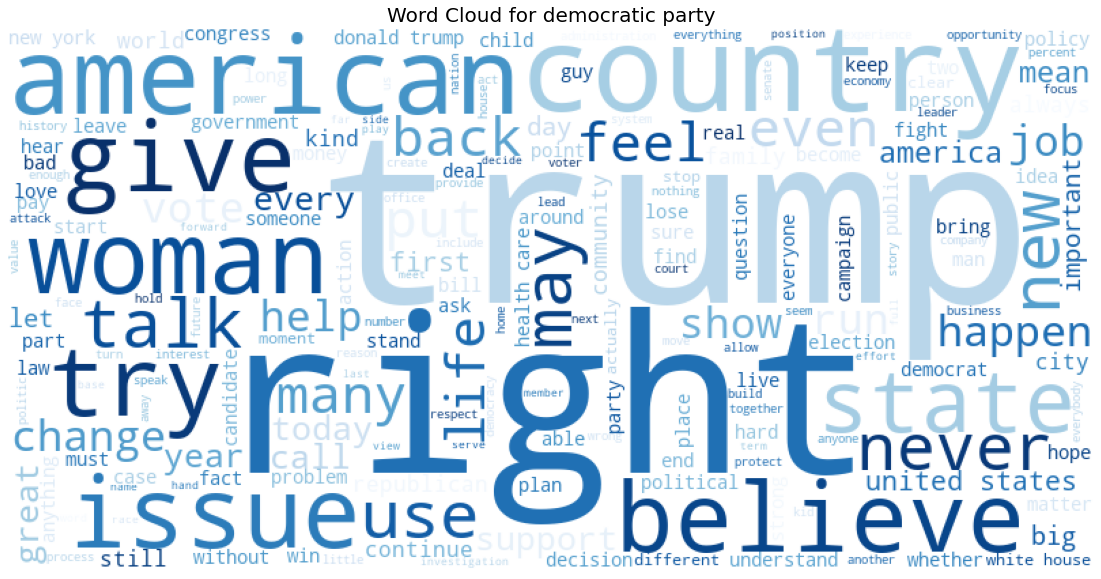

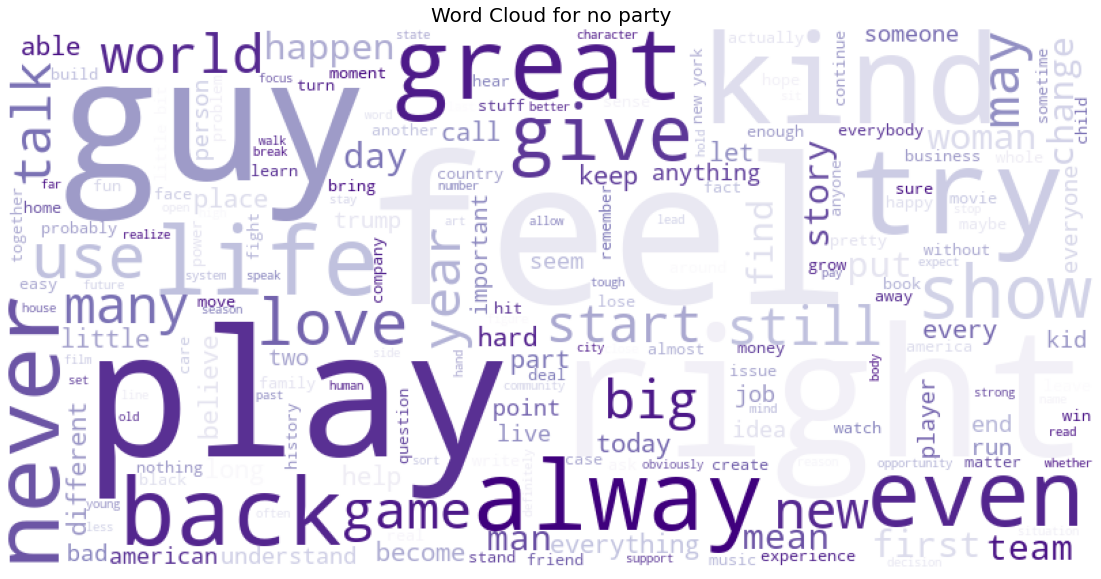

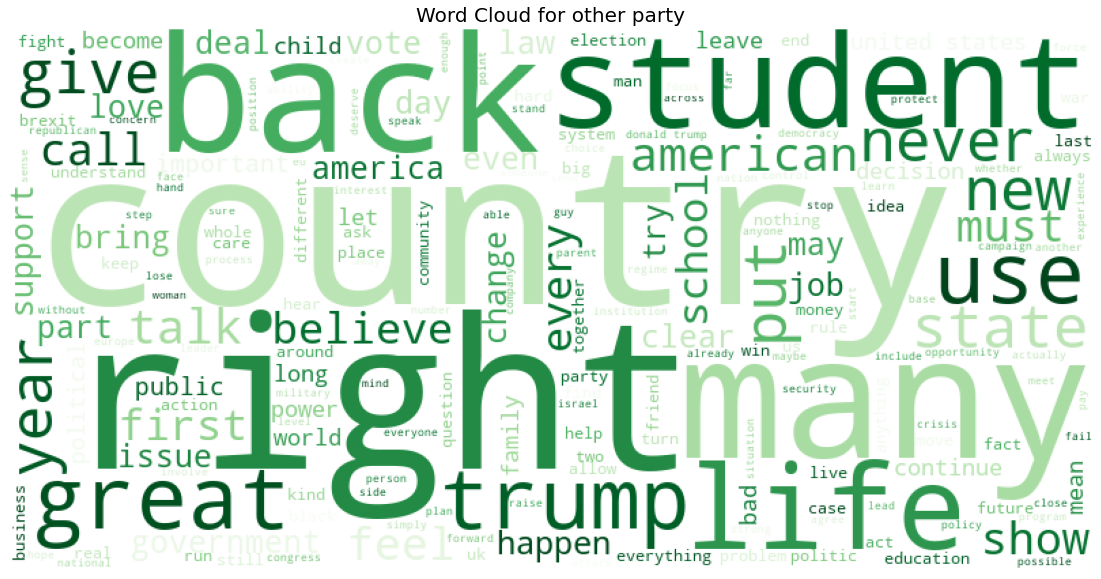

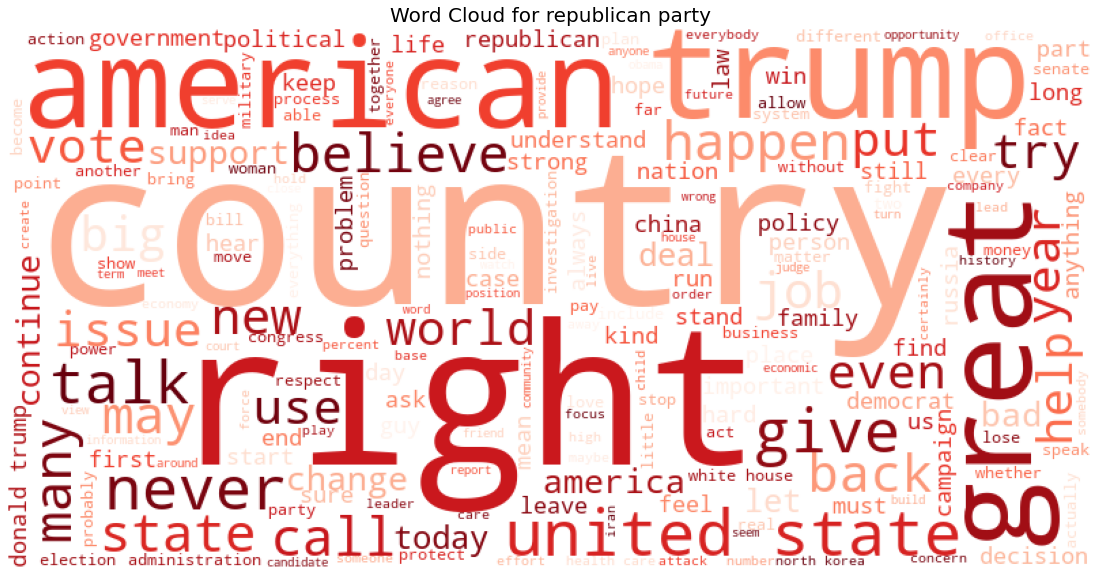

In [34]:
# Generate word clouds for each party category
speakers.groupby('party_name').apply(create_cloud_party)

Of course, the plots show a lot irrelevant words, as we haven't selected the most pertinent topics yet. Some words can still be very meaningful of the party (e.g. "women", "child", "health care" for the democrats; "military", "China", "North Korea" for the republicans).
By filtering these words, as it will be done with the dictionaries, we would maybe highlight some very evocative ideas in each party. 
Note that we are mainly interested in the republican and democrats plots but we an use the other two as references.

## 6. First steps towards sentiment analysis

An important part of the project will concern **sentiment analysis**. Sentiment analysis is the practice of using algorithms to classify various samples of related text into overall positive and negative categories.

To perform sentiment analysis, we use the Python library [NLTK](https://www.nltk.org/). It stands for Natural Language Toolkit and includes a sentiment analyzer. This analyzer can be trained on custom data. For this notebook, we use the built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

For this project, we need to extract from the quotations the political ideas of a speaker. Our strategy is to evaluate the point of view of a speaker on different topics. To do so, one could proceed the following way:

- Train a sentiment analyzer for a particular topic
- Run the analyzer on each quote of a speaker
- Average the scores for the speaker

This way, we could have a score for the speaker that we would use to determine the political ideas.

Before doing so, let's show how to use the sentiment analyzer.

In [35]:
# Download lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [36]:
# NLTK’s Pre-Trained Sentiment Analyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('ADA is awesome!')

{'compound': 0.6588, 'neg': 0.0, 'neu': 0.313, 'pos': 0.687}

We get back a dictionary of different scores. The negative, neutral, and positive scores are related: they all add up to 1 and can’t be negative. The compound score is calculated differently. It’s not just an average, and it can range from -1 to 1.

For example, we analyze the quotations of Donald Trump using the VADER analyzer.

In [37]:
# Select Trump's quotes
trump_mask = data_NYT.qids.apply(lambda x: 'Q22686' in x)
df_trump = data_NYT[trump_mask]
df_trump

,quotation,speaker,qids,date,numOccurrences,tokenized_quotations
quoteID,,,,,,
2015-04-28-037816,Our great African-American president hasn't ex...,none,"[Q22686, Q27947481]",2015-04-28 11:44:39,31,great african american president have not ex...
2015-08-25-088374,The hedge fund guys didn't build this country.,none,"[Q22686, Q27947481]",2015-08-25 12:00:07,42,the hedge fund guy do not build this country
2015-09-25-098815,"These are guys that shift paper around, and th...",none,"[Q22686, Q27947481]",2015-09-25 10:41:12,57,these be guy that shift paper around and get...
2015-08-18-085158,The point is that if you are a little differen...,none,"[Q22686, Q27947481]",2015-08-18 21:49:57,68,the point be that if be a little different o...
2015-10-11-036927,"Little Barry Diller, who lost a fortune on New...",none,"[Q22686, Q27947481]",2015-10-11 14:18:55,12,little barry diller who lose a fortune on new...
...,...,...,...,...,...,...
2020-01-08-061443,"remain until Iran changes its behavior,",president donald trump,[Q22686],2020-01-08 00:00:00,12,remain until iran change behavior
2020-03-25-089075,"We'll be helping the airlines, the cruise lines.",president trump,[Q22686],2020-03-25 18:53:42,3,will be help the airline the cruise line
2020-01-29-063402,Maybe I'm being just nice to them because I ne...,president trump,[Q22686],2020-01-29 12:04:14,16,maybe be be just nice to because need vote


We then get the compound scores to analyze both negative and positive quotations.

In [38]:
def get_compound_score(text):
    """Returns the compound score for a quotation."""
    return sia.polarity_scores(text)['compound']


# Get compound score of all quotations
df_trump['compound_score'] = df_trump.apply(
    lambda x: get_compound_score(x.quotation), axis=1)
df_trump

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,quotation,speaker,qids,date,numOccurrences,tokenized_quotations,compound_score
quoteID,,,,,,,
2015-04-28-037816,Our great African-American president hasn't ex...,none,"[Q22686, Q27947481]",2015-04-28 11:44:39,31,great african american president have not ex...,0.5399
2015-08-25-088374,The hedge fund guys didn't build this country.,none,"[Q22686, Q27947481]",2015-08-25 12:00:07,42,the hedge fund guy do not build this country,0.0000
2015-09-25-098815,"These are guys that shift paper around, and th...",none,"[Q22686, Q27947481]",2015-09-25 10:41:12,57,these be guy that shift paper around and get...,0.4215
2015-08-18-085158,The point is that if you are a little differen...,none,"[Q22686, Q27947481]",2015-08-18 21:49:57,68,the point be that if be a little different o...,-0.2280
2015-10-11-036927,"Little Barry Diller, who lost a fortune on New...",none,"[Q22686, Q27947481]",2015-10-11 14:18:55,12,little barry diller who lose a fortune on new...,-0.9098
...,...,...,...,...,...,...,...
2020-01-08-061443,"remain until Iran changes its behavior,",president donald trump,[Q22686],2020-01-08 00:00:00,12,remain until iran change behavior,0.0000
2020-03-25-089075,"We'll be helping the airlines, the cruise lines.",president trump,[Q22686],2020-03-25 18:53:42,3,will be help the airline the cruise line,0.2960
2020-01-29-063402,Maybe I'm being just nice to them because I ne...,president trump,[Q22686],2020-01-29 12:04:14,16,maybe be be just nice to because need vote,0.4215


Now we can identify the quotations with respectively the most positive and negative connotation, according to the compound score, and look at the distribution of this score.

In [39]:
# Most positive quotation
df_trump.loc[df_trump['compound_score'].idxmax()].quotation

'I happen to have a tremendous feeling for Mexican-Americans not only in terms of friendships, but in terms of the tremendous numbers that I employ in the United States and they are amazing people, amazing people. I have many friends, so many friends and so many friends coming to Mexico and in Mexico. I am proud to say how many people I employ. And the United States first, second and third generation Mexicans are just beyond reproach. Spectacular, spectacular hard-working people. I have such great respect for them and their strong values of family, faith and community.'

In [40]:
# Most negative quotation
df_trump.loc[df_trump['compound_score'].idxmin()].quotation

'After four years of Hillary Clinton, what do we have? ISIS has spread across the region, and the entire world. Libya is in ruins, and our ambassador and his staff were left helpless to die at the hands of savage killers. Egypt was turned over to the radical Muslim Brotherhood, forcing the military to retake control. Iraq is in chaos. Iran is on the path to nuclear weapons. Syria is engulfed in a civil war and a refugee crisis now threatens the West.... This is the legacy of Hillary Clinton: death, destruction, terrorism and weakness.'

Indeed, we observe that the sentiment analysis worked.

Text(0.5, 1.0, "Distribution of compound score for Trump's quotations")

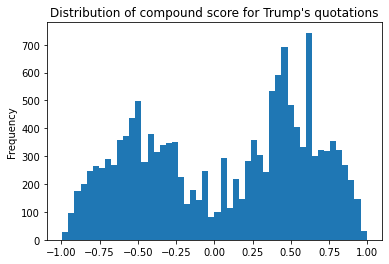

In [41]:
# Distribution of compound score (without neutral quotations)
df_trump[df_trump.compound_score != 0].compound_score.plot.hist(bins=50)
plt.title('Distribution of compound score for Trump\'s quotations')

With this last graph, we have a confirmation that Trump tends to have either very optimistic or very pessimistic words. The zero compound quotes (perfectly neutral quotes) are ignored because they are too frequent and not interesting for the analysis.

## References

- [WordCloud Documentation](https://amueller.github.io/word_cloud/)
- [Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)
- [Simple word cloud in Python](https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5)
- [Sentiment Analysis: First Steps With Python's NLTK Library](https://realpython.com/python-nltk-sentiment-analysis/)
- [NLTK Documentation](https://www.nltk.org/index.html)